In [22]:
import numpy as np
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input, Concatenate
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.datasets import mnist

## load mnist dataset

In [5]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [6]:
x_train.shape

(60000, 28, 28)

In [7]:
y_train.shape

(60000,)

In [8]:
x_test.shape

(10000, 28, 28)

In [9]:
y_test.shape

(10000,)

## get number of labels

In [10]:
num_labels = len(np.unique(y_train))
num_labels

10

## convert to one-hot vector

In [11]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [12]:
y_train.shape

(60000, 10)

In [13]:
y_test.shape

(10000, 10)

## input image dimensions

In [14]:
image_size = x_train.shape[1]
image_size

28

## resize and normalize

In [15]:
x_train = np.reshape(x_train,[-1, image_size, image_size, 1])
x_test = np.reshape(x_test,[-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [16]:
x_train.shape

(60000, 28, 28, 1)

In [17]:
x_test.shape

(10000, 28, 28, 1)

## network parameters

In [18]:
input_shape = (image_size, image_size, 1)
batch_size = 32
kernel_size = 3
dropout = 0.4
n_filters = 32

## create model

In [23]:
# left branch of Y network
left_inputs = Input(shape=input_shape)
x = left_inputs
filters = n_filters
# 3 layers of Conv2D-Dropout-MaxPooling2D
# number of filters doubles after each layer (32-64-128)
for i in range(3):
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               padding='same',
               activation='relu')(x)
    x = Dropout(dropout)(x)
    x = MaxPooling2D()(x)
    filters *= 2

# right branch of Y network
right_inputs = Input(shape=input_shape)
y = right_inputs
filters = n_filters
# 3 layers of Conv2D-Dropout-MaxPooling2D
# number of filters doubles after each layer (32-64-128)
for i in range(3):
    y = Conv2D(filters=filters,
               kernel_size=kernel_size,
               padding='same',
               activation='relu',
               dilation_rate=2)(y)
    y = Dropout(dropout)(y)
    y = MaxPooling2D()(y)
    filters *= 2

# merge left and right branches outputs
y = Concatenate()([x, y])
# feature maps to vector in preparation to connecting to Dense layer
y = Flatten()(y)
y = Dropout(dropout)(y)
outputs = Dense(num_labels, activation='softmax')(y)

# build the model in functional API
model = Model([left_inputs, right_inputs], outputs)
# verify the model using graph
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 28, 28, 32)   320         input_7[0][0]                    
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 28, 28, 32)   320         input_8[0][0]                    
______________________________________________________________________________________________

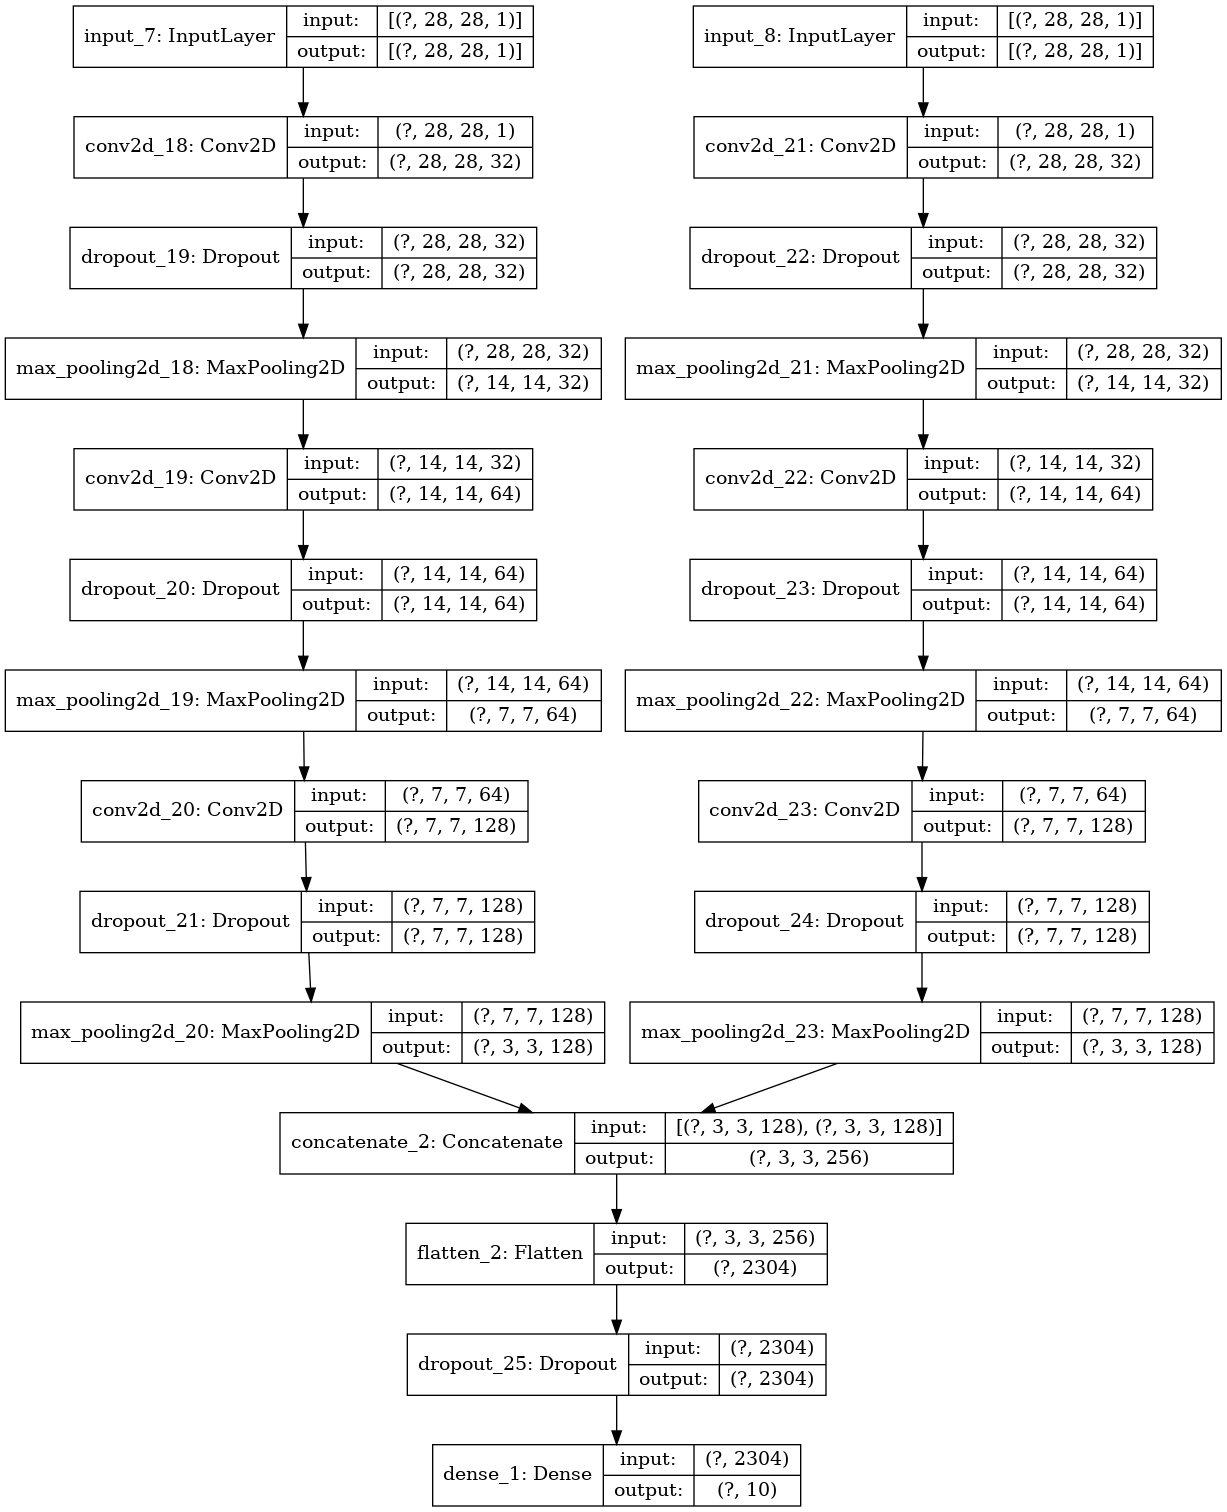

In [24]:
plot_model(model, to_file='cnn-y-network.png', show_shapes=True, show_layer_names=True)
from IPython.display import Image
Image(retina=True, filename='cnn-y-network.png')

## Compile the model

In [25]:
# loss function for one-hot vector
# use of adam optimizer
# accuracy is good metric for classification tasks
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

## train

In [28]:
model.fit([x_train, x_train],
          y_train, 
          validation_data=([x_test, x_test], y_test),
          epochs=20,
          batch_size=batch_size)

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 58s 965us/sample - loss: 0.1746 - accuracy: 0.9447 - val_loss: 0.1531 - val_accuracy: 0.9870
Epoch 2/20
60000/60000 [==============================] - 41s 689us/sample - loss: 0.0646 - accuracy: 0.9801 - val_loss: 0.0753 - val_accuracy: 0.9908
Epoch 3/20
60000/60000 [==============================] - 43s 711us/sample - loss: 0.0532 - accuracy: 0.9836 - val_loss: 0.0772 - val_accuracy: 0.9907
Epoch 4/20
60000/60000 [==============================] - 50s 830us/sample - loss: 0.0460 - accuracy: 0.9862 - val_loss: 0.0511 - val_accuracy: 0.9928
Epoch 5/20
60000/60000 [==============================] - 53s 889us/sample - loss: 0.0450 - accuracy: 0.9856 - val_loss: 0.0953 - val_accuracy: 0.9920
Epoch 6/20
60000/60000 [==============================] - 43s 714us/sample - loss: 0.0399 - accuracy: 0.9876 - val_loss: 0.0501 - val_accuracy: 0.9938
Epoch 7/20
60000/60000 [====================

In [30]:
loss, acc = model.evaluate([x_test, x_test], y_test, batch_size=batch_size)
print("\nTest accuracy: %.1f%%" % (100.0 * acc))

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


Test accuracy: 99.3%


In [34]:
import sklearn.metrics as metrics

y_pred_ohe = model.predict([x_test, x_test])   
y_pred_labels = np.argmax(y_pred_ohe, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

confusion_matrix = metrics.confusion_matrix(y_true=y_true_labels, y_pred=y_pred_labels)  
confusion_matrix

array([[ 979,    0,    0,    0,    0,    0,    0,    1,    0,    0],
       [   3, 1129,    0,    1,    0,    0,    0,    1,    1,    0],
       [   1,    0, 1021,    3,    1,    0,    0,    5,    1,    0],
       [   0,    0,    0, 1008,    0,    0,    0,    0,    2,    0],
       [   0,    0,    0,    0,  973,    0,    1,    0,    1,    7],
       [   2,    0,    0,    7,    0,  880,    2,    0,    0,    1],
       [   2,    2,    0,    0,    1,    0,  950,    0,    2,    1],
       [   0,    3,    2,    0,    0,    0,    0, 1022,    1,    0],
       [   0,    0,    0,    1,    0,    0,    0,    0,  971,    2],
       [   0,    0,    0,    2,    5,    2,    0,    2,    1,  997]])

In [35]:
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     verticalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     verticalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

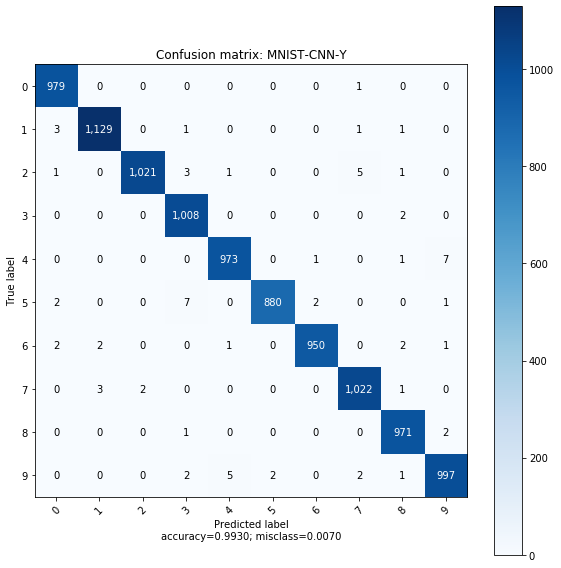

In [36]:
title = 'Confusion matrix: MNIST-CNN-Y'
target_names = [0,1,2,3,4,5,6,7,8,9]
plot_confusion_matrix(confusion_matrix, target_names, title=title, cmap=None, normalize=False)